# Анализ картинок

Создайте эмбеддинги изображений и отобразите их в tensorboard projector'е

1. Скачайте датасет [CelebA](https://pytorch.org/vision/stable/datasets.html#celeba) или любой другой не рассмотренный на лекции
1. Выберите одну из предобученных [моделей torchvision](https://pytorch.org/vision/stable/models.html)
1. Создайте эмбеддинги изображений из датасета
1. Визуализируйте эмбеддинги в tensorboard projector

# Лена

Примените фильтр к изображению Лены

1. Скачайте изображение [Лены](http://optipng.sourceforge.net/pngtech/img/lena.png)
1. Найдите фильтр для выделения признака на изображении. В лекции показан пример фильтра Собеля. Использовать примеры с лекций нельзя. Начать поиск фильтра можно с [этой страницы](https://en.wikipedia.org/wiki/Feature_(computer_vision)#Extraction)
1. Реализуйте процедуру свёртки изображения с фильтром
1. Сверните Лену

In [1]:
from platform import python_version
import cv2
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(f'Opencv version: {cv2.__version__}. \
        \nPython version: {python_version()}. \
        \nTorch version: {torch.__version__} \
        \nTorchvision version: {torchvision.__version__}')

Opencv version: 4.5.4.         
Python version: 3.9.9.         
Torch version: 1.10.0+cu113         
Torchvision version: 0.11.1+cu113


In [3]:
import random
import numpy as np

import torch
import torch.nn as nn

import scipy

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
from torchvision.models import resnet50

from tqdm.notebook import tqdm, trange

# Фиксируем random seed для воспроизводимости результатов
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True


OUTPUT_DIM = 10  # Количество классов
EPOCH_NUM = 4  # Сколько эпох будет обучать модель

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [4]:
basic_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])  # Базовые аугментации для тренировочных данных (грубо говоря бесплатное увеличение тренировочной выборки)

In [5]:
# Загрузим данные

train_dataset = SVHN(
    root='./SVHN/train',
    split='train',
    transform=basic_transform,
    download=True
)

test_dataset = SVHN(
    root='./SVHN/test',
    split='test',
    transform=transforms.ToTensor(),  # Для тестовых данные НЕ НАДО использовать никакие аугментации
    download=True
)

Using downloaded and verified file: ./SVHN/train\train_32x32.mat
Using downloaded and verified file: ./SVHN/test\test_32x32.mat


In [6]:
dataloaders = {
    'train': DataLoader(
        dataset=train_dataset,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=test_dataset,
        batch_size=128, 
        shuffle=False
    )
}

In [7]:
class SVHNClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(SVHNClassifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = resnet50(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели
        
        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    
    def embed(self, x):
        return self.fc1(self.model(x))
    
    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [8]:
model = SVHNClassifier(OUTPUT_DIM)
model = model.to(DEVICE)

# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
# Более подробно об этом будет в курсе машинного обучения
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [9]:
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Важно! В данном примере точность используется для упрощения.
# Никогда не используйте её если у вас несбалансированная выборка
# Возьмите лучше F_score или ROC_AUC (об этом вам потом расскажут)

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):
    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            X_batch = X_batch / 255
            X_batch = transforms.Normalize((0.4380, 0.4440, 0.4730), (0.1751, 0.1771, 0.1744))(X_batch)
            
            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)
                
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
                   
            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2818 Acc: 0.1719 

Epoch: 1. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2289 Acc: 0.2031 

Epoch: 2. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2409 Acc: 0.1882 

Epoch: 2. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2146 Acc: 0.2054 

Epoch: 3. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2321 Acc: 0.1911 

Epoch: 3. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2079 Acc: 0.2106 

Epoch: 4. Phase: train:   0%|          | 0/573 [00:00<?, ?it/s]

train Loss: 2.2271 Acc: 0.1948 

Epoch: 4. Phase: val:   0%|          | 0/204 [00:00<?, ?it/s]

val Loss: 2.2031 Acc: 0.2145 

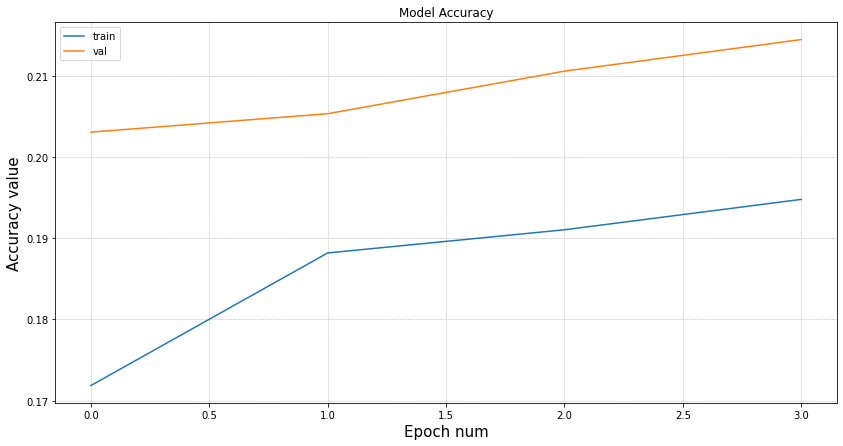

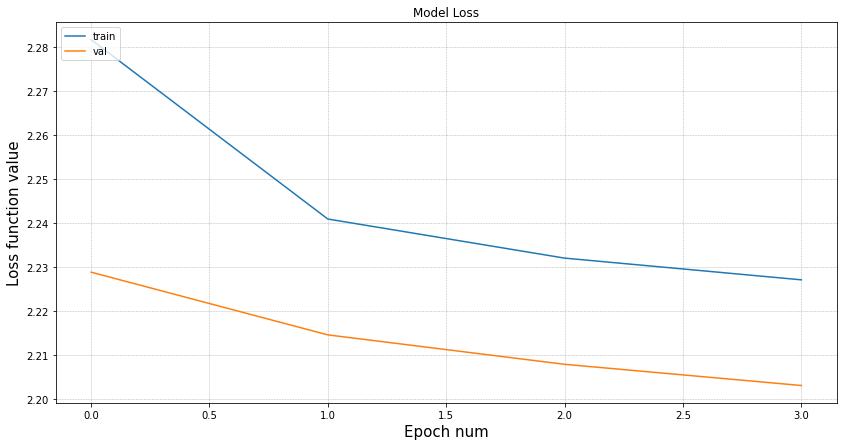

In [10]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

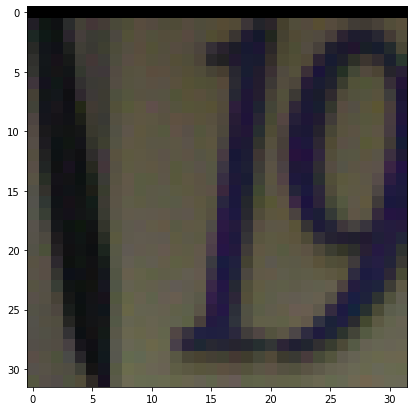

In [11]:
img = train_dataset[0][0].detach().numpy()

plt.imshow(np.transpose(img, (1,2,0)))

In [12]:
train_items = [train_dataset[i] for i in range(1000)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
xs = transforms.Normalize((0.4380, 0.4440, 0.4730), (0.1751, 0.1771, 0.1744))(xs)

xs.size()

torch.Size([1000, 3, 32, 32])

In [13]:
embs = model.embed(xs.to(DEVICE))
embs.size()

torch.Size([1000, 64])

In [14]:
import umap

points = umap.UMAP().fit_transform(embs.cpu().detach().numpy())
points.shape

(1000, 2)

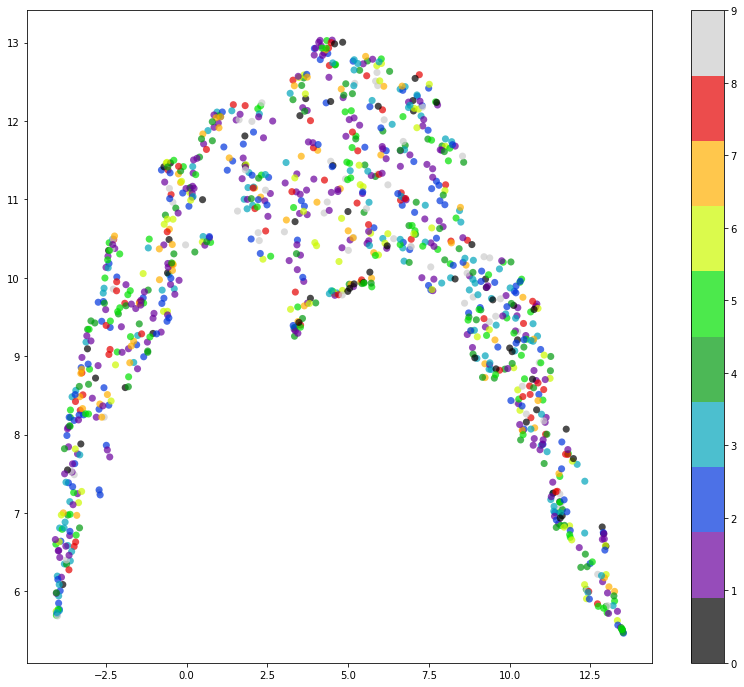

In [15]:
plt.figure(figsize=(14,12))
plt.scatter(points[:, 0], points[:, 1], c=ys, 
            edgecolor='none', alpha=0.7, s=50,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.show()

In [16]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

In [17]:
# log embeddings
import tensorflow as tf
import tensorboard as tb

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer.add_embedding(embs.cpu(),
                     metadata=ys,
                     label_img=xs)
writer.close()

In [18]:
# !tensorboard --logdir runs

# Лена


In [19]:
!curl http://optipng.sourceforge.net/pngtech/img/lena.png --output ./images/lena.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  3  462k    3 15694    0     0  15694      0  0:00:30 --:--:--  0:00:30 23923
 47  462k   47  222k    0     0   222k      0  0:00:02  0:00:01  0:00:01  140k
 95  462k   95  443k    0     0   221k      0  0:00:02  0:00:02 --:--:--  178k
100  462k  100  462k    0     0   231k      0  0:00:02  0:00:02 --:--:--  186k


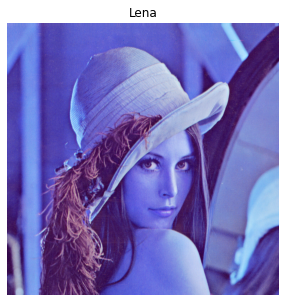

In [20]:
img = cv2.imread('images/lena.png')  # Загрузка/чтение изображения

plt.figure(figsize=(15, 5))
plt.title('Lena')
plt.imshow(img)
plt.axis('off')
plt.show()

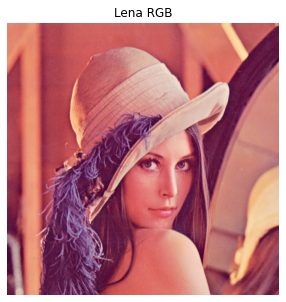

In [21]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

plt.figure(figsize=(15, 5))
plt.title('Lena RGB')
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

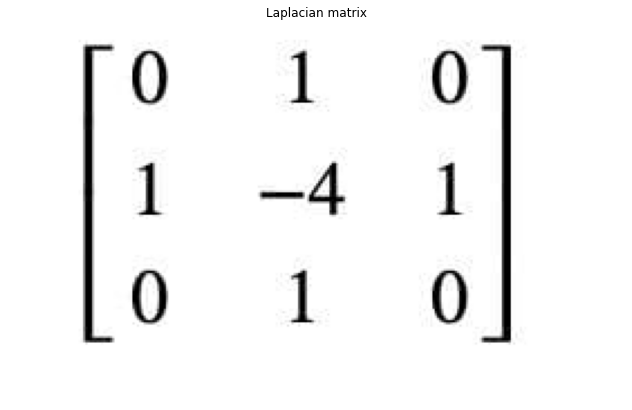

In [22]:
plt.imshow(cv2.imread('images/matrix.png'))
plt.title('Laplacian matrix')
plt.axis('off')
plt.show()

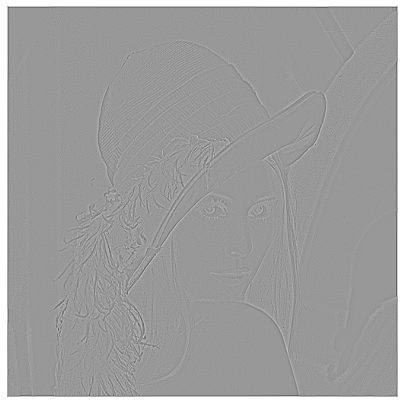

In [23]:
# converting to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# remove noise
img_gray = cv2.blur(gray, ksize=(5, 5))

kernel = np.array([[0,1,0],[1,-4,1],[0,1,0]])
from scipy.signal import convolve2d
img_conv=convolve2d(gray, kernel)
plt.figure(figsize=(7, 10))
plt.axis('off')
plt.imshow(img_conv, cmap='gray')

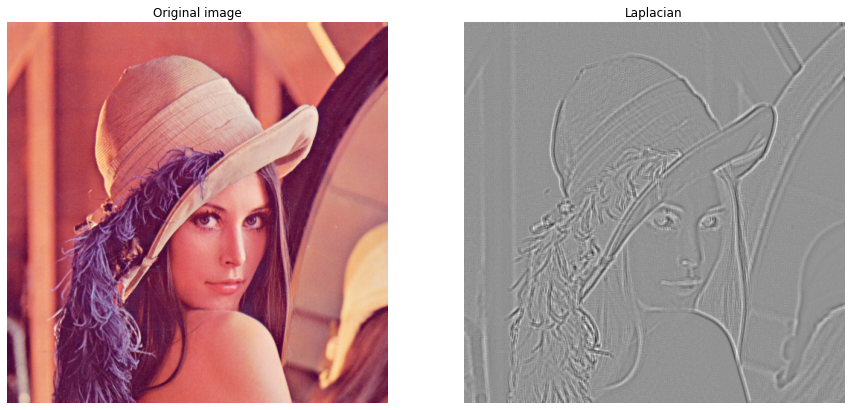

In [24]:
# convolute with proper kernels
laplacian = cv2.Laplacian(img_gray,cv2.CV_64F)

plt.figure(figsize=(15, 10))

ax = plt.subplot(121)
ax.set_title('Original image')
ax.axis('off')
ax.imshow(img_rgb)

ax = plt.subplot(122)
ax.set_title('Laplacian')
ax.axis('off')
ax.imshow(laplacian, cmap='gray');